# Backtest Playground (15m / 1y)

`Run -> Run All Cells` で 15分足1年分のデータ取得とバックテストを実行します。

15mモデルは本番ロジックと同様に、4h上位トレンド（EMA9/34）で `LONG/SHORT` を自動切替します。


In [1]:
from pathlib import Path
import os
import sys

CANDIDATE_ROOTS = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/Users/umegakigen/gitProjects/crypto_trade_bot'),
]

ROOT = None
for candidate in CANDIDATE_ROOTS:
    if (candidate / 'pybot').exists() and (candidate / 'research').exists():
        ROOT = candidate
        break

if ROOT is None:
    raise RuntimeError('project root not found')

os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('ROOT =', ROOT)


ROOT = /Users/umegakigen/gitProjects/crypto_trade_bot


In [2]:
# Parameters
PAIR = 'SOL/USDC'
TIMEFRAME = '15m'
YEARS_OF_DATA = 1.0
REFRESH_DATA = False

CONFIG_PATH = ROOT / 'research/models/ema_pullback_15m_both_v0/config/current.json'
CSV_PATH = ROOT / 'research/data/raw/solusdc_15m_1y.csv'
OUTPUT_PATH = ROOT / 'research/data/processed/backtest_15m_1y_latest.json'
INITIAL_CAPITAL_JPY = 1_000_000


print('PAIR =', PAIR)
print('TIMEFRAME =', TIMEFRAME)
print('YEARS_OF_DATA =', YEARS_OF_DATA)
print('REFRESH_DATA =', REFRESH_DATA)
print('CONFIG_PATH =', CONFIG_PATH)
print('CSV_PATH =', CSV_PATH)
print('OUTPUT_PATH =', OUTPUT_PATH)
print('INITIAL_CAPITAL_JPY =', INITIAL_CAPITAL_JPY)


print('UPPER_TREND_SWITCH = 4h EMA9/34 (UP=LONG, DOWN=SHORT)')
print('SHORT_GUARDRAILS = 4h EMA gap>=0.2%, breakdown(close<last6 low), cooldown=8 bars after short STOP_LOSS')


PAIR = SOL/USDC
TIMEFRAME = 15m
YEARS_OF_DATA = 1.0
REFRESH_DATA = False
CONFIG_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/models/ema_pullback_15m_both_v0/config/current.json
CSV_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_15m_1y.csv
OUTPUT_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_15m_1y_latest.json
INITIAL_CAPITAL_JPY = 1000000
UPPER_TREND_SWITCH = 4h EMA9/34 (UP=LONG, DOWN=SHORT)
SHORT_GUARDRAILS = 4h EMA gap>=0.2%, breakdown(close<last6 low), cooldown=8 bars after short STOP_LOSS


In [3]:
import subprocess

fetch_cmd = [
    sys.executable,
    '-m',
    'research.scripts.fetch_ohlcv',
    '--pair',
    PAIR,
    '--timeframe',
    TIMEFRAME,
    '--years',
    str(YEARS_OF_DATA),
    '--output',
    str(CSV_PATH),
]
if REFRESH_DATA:
    fetch_cmd.append('--refresh')

print('[run]', ' '.join(fetch_cmd))
subprocess.run(fetch_cmd, cwd=str(ROOT), check=True)


[run] /Users/umegakigen/gitProjects/crypto_trade_bot/.venv/bin/python3 -m research.scripts.fetch_ohlcv --pair SOL/USDC --timeframe 15m --years 1.0 --output /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_15m_1y.csv
[research] ohlcv reused {'pair': 'SOL/USDC', 'timeframe': '15m', 'target_bars': 35040, 'bars': 35040, 'first_close': '2025-02-24T14:30:00Z', 'last_close': '2026-02-24T14:15:00Z', 'output': '/Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_15m_1y.csv'}


CompletedProcess(args=['/Users/umegakigen/gitProjects/crypto_trade_bot/.venv/bin/python3', '-m', 'research.scripts.fetch_ohlcv', '--pair', 'SOL/USDC', '--timeframe', '15m', '--years', '1.0', '--output', '/Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_15m_1y.csv'], returncode=0)

In [4]:
import json

backtest_cmd = [
    sys.executable,
    '-m',
    'research.scripts.run_backtest',
    '--config',
    str(CONFIG_PATH),
    '--bars',
    str(CSV_PATH),
    '--output',
    str(OUTPUT_PATH),
]

print('[run]', ' '.join(backtest_cmd))
subprocess.run(backtest_cmd, cwd=str(ROOT), check=True)

report = json.loads(OUTPUT_PATH.read_text(encoding='utf-8'))
summary = report.get('summary', {})
reasons = report.get('no_signal_reason_counts', {})
top_reasons = sorted(reasons.items(), key=lambda item: item[1], reverse=True)[:10]

print('[summary]', summary)
print('[top_no_signal_reasons]', top_reasons)

print('[ema_long_trend_filter_failed]', reasons.get('EMA_TREND_FILTER_FAILED', 0))
print('[ema_short_trend_filter_failed]', reasons.get('EMA_SHORT_TREND_FILTER_FAILED', 0))
print('[short_pullback_not_found]', reasons.get('SHORT_PULLBACK_NOT_FOUND', 0))
print('[short_reclaim_not_found]', reasons.get('SHORT_RECLAIM_NOT_FOUND', 0))
print('[short_upper_trend_too_weak]', reasons.get('SHORT_UPPER_TREND_TOO_WEAK', 0))
print('[short_breakdown_not_confirmed]', reasons.get('SHORT_BREAKDOWN_NOT_CONFIRMED', 0))
print('[short_cooldown_after_stop_loss_active]', reasons.get('SHORT_COOLDOWN_AFTER_STOP_LOSS_ACTIVE', 0))
print('[upper_trend_ema_not_stable]', reasons.get('UPPER_TREND_EMA_NOT_STABLE', 0))
print('[saved]', OUTPUT_PATH)


[run] /Users/umegakigen/gitProjects/crypto_trade_bot/.venv/bin/python3 -m research.scripts.run_backtest --config /Users/umegakigen/gitProjects/crypto_trade_bot/research/models/ema_pullback_15m_both_v0/config/current.json --bars /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_15m_1y.csv --output /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_15m_1y_latest.json
[research] backtest completed {'total_bars': 35040, 'decision_enter_count': 492, 'decision_no_signal_count': 23999, 'closed_trades': 491, 'open_trades': 1, 'wins': 200, 'losses': 291, 'win_rate_pct': 40.7332, 'average_pnl_pct': 0.140978, 'total_pnl_pct': 69.220077, 'average_scaled_pnl_pct': 0.140974, 'total_scaled_pnl_pct': 69.21831, 'average_r_multiple': 0.121694, 'first_bar_close_time': '2025-02-24T14:30:00Z', 'last_bar_close_time': '2026-02-24T14:15:00Z'}
[research] top no-signal reasons [('EMA_SHORT_TREND_FILTER_FAILED', 6652), ('MAX_TRADES_PER_DAY_REACHED', 5909), ('EM

## Charts

2時間足Notebookと同様に、主要な可視化を表示します。

上位4hトレンドで `LONG/SHORT` が切り替わるため、方向別の件数と方向別PnLも確認します。

SHORTには以下のガードが入っています。
- 4h EMAギャップ強度フィルタ（0.2%以上）
- ブレイクダウン確認（終値が直近6本安値を下抜け）
- SHORT STOP_LOSS後の8バークールダウン


[chart] closed_trades = 491
[chart] wins/losses = 200 / 291
[tp_r_sweep] range {'start': 1.5, 'end': 3.0, 'step': 0.1}
{'r_multiple': 1.5, 'closed_trades': 541, 'win_rate_pct': 44.3623, 'total_pnl_pct': 58.907419, 'total_scaled_pnl_pct': 58.906795, 'average_scaled_pnl_pct': 0.108885}
{'r_multiple': 1.6, 'closed_trades': 524, 'win_rate_pct': 43.3206, 'total_pnl_pct': 65.630676, 'total_scaled_pnl_pct': 65.630976, 'average_scaled_pnl_pct': 0.12525}
{'r_multiple': 1.7, 'closed_trades': 511, 'win_rate_pct': 41.683, 'total_pnl_pct': 62.936152, 'total_scaled_pnl_pct': 62.936613, 'average_scaled_pnl_pct': 0.123164}
{'r_multiple': 1.8, 'closed_trades': 491, 'win_rate_pct': 40.7332, 'total_pnl_pct': 69.220077, 'total_scaled_pnl_pct': 69.21831, 'average_scaled_pnl_pct': 0.140974}
{'r_multiple': 1.9, 'closed_trades': 483, 'win_rate_pct': 38.5093, 'total_pnl_pct': 53.402314, 'total_scaled_pnl_pct': 53.401417, 'average_scaled_pnl_pct': 0.110562}
{'r_multiple': 2.0, 'closed_trades': 473, 'win_rate_pc

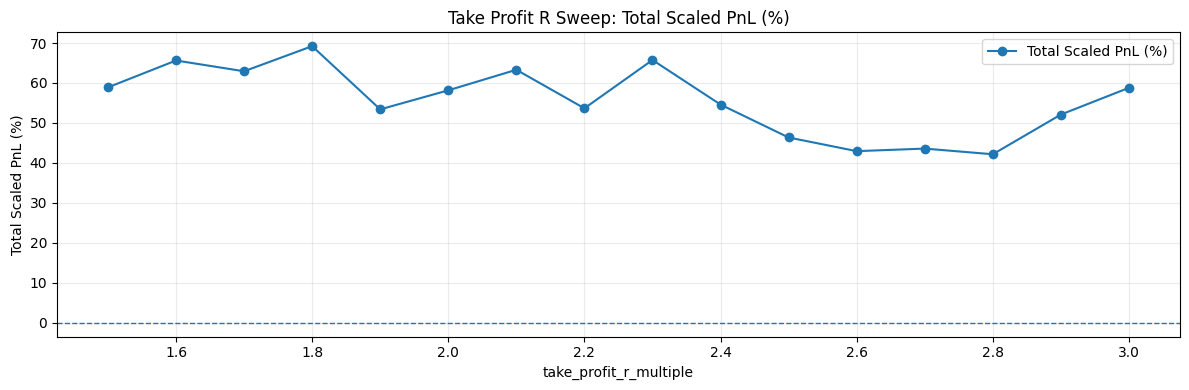

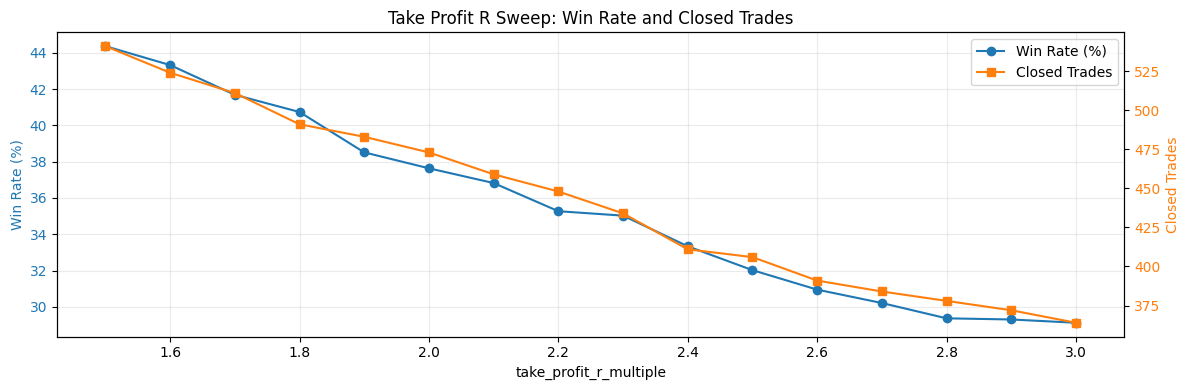

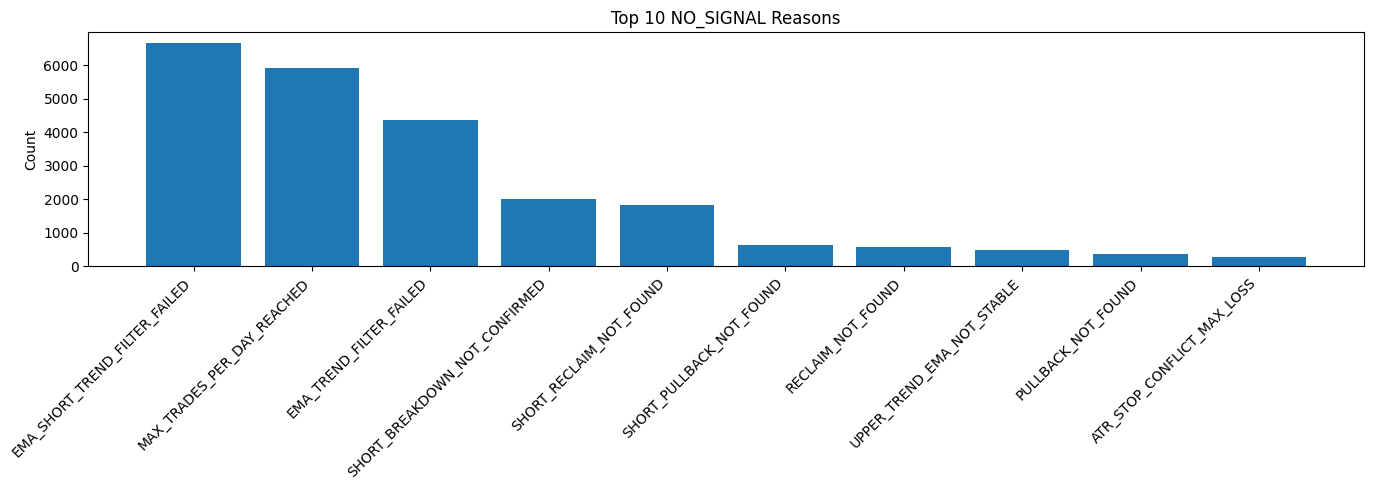

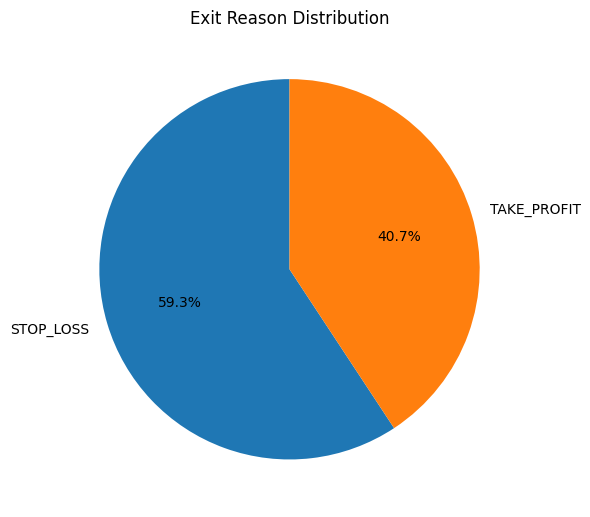

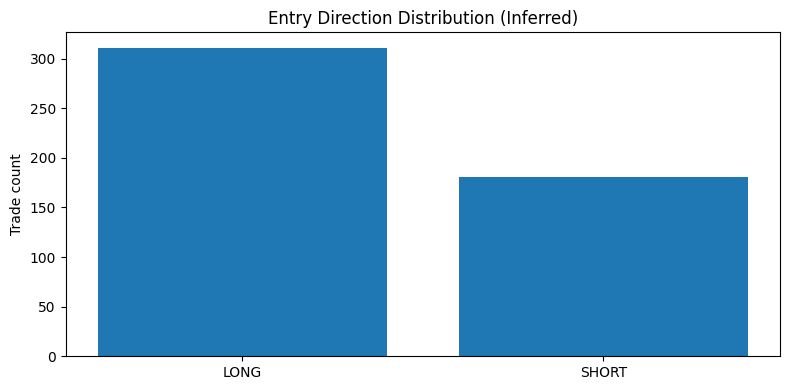

{'all_trade_direction_counts': {'LONG': 311, 'SHORT': 181}, 'closed_trade_direction_counts': {'LONG': 311, 'SHORT': 180}}
{'directional_total_pnl_pct': {'LONG': 42.466913, 'SHORT': 26.751397}, 'pnl_metric_key': 'scaled_pnl_pct'}
{'pnl_metric_key': 'scaled_pnl_pct', 'initial_capital_jpy': 1000000, 'final_asset_jpy': 1884805.91, 'total_return_pct': 88.4806, 'max_drawdown_pct': -17.4662, 'max_drawdown_trade_index': 406}


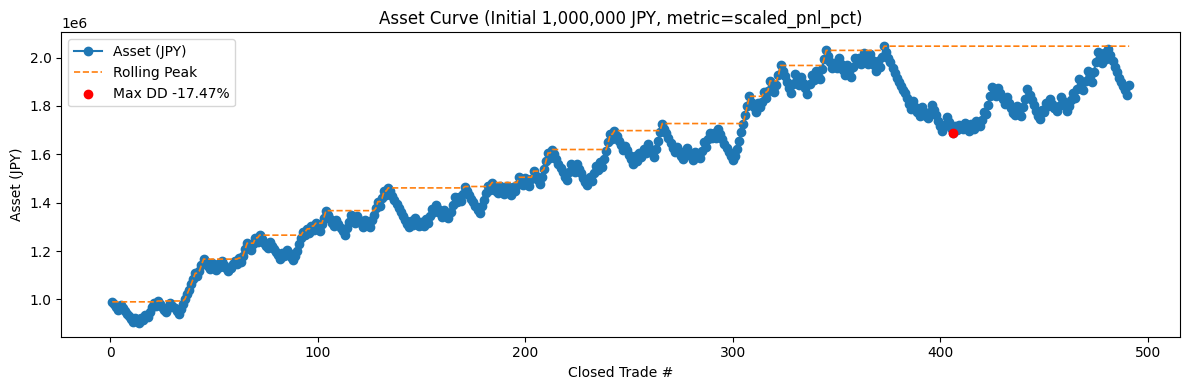

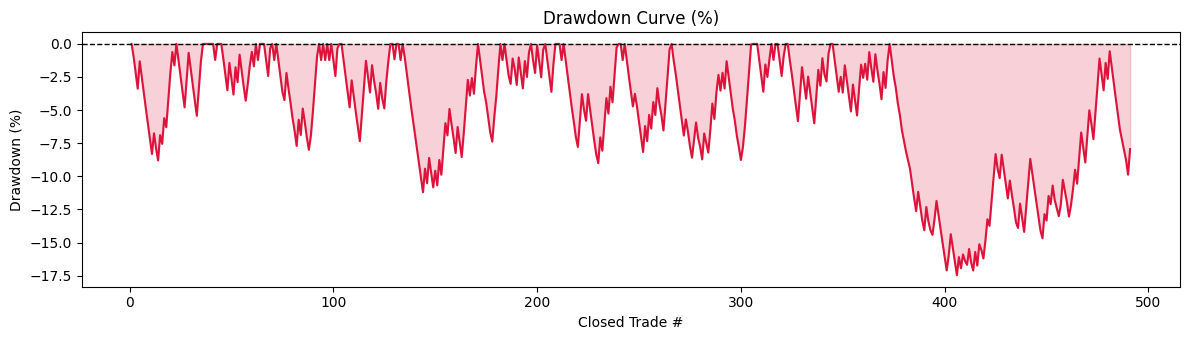

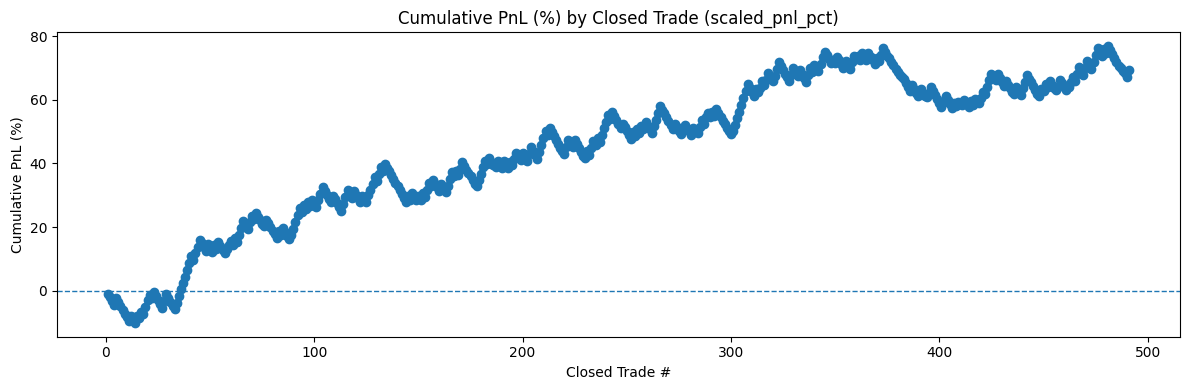

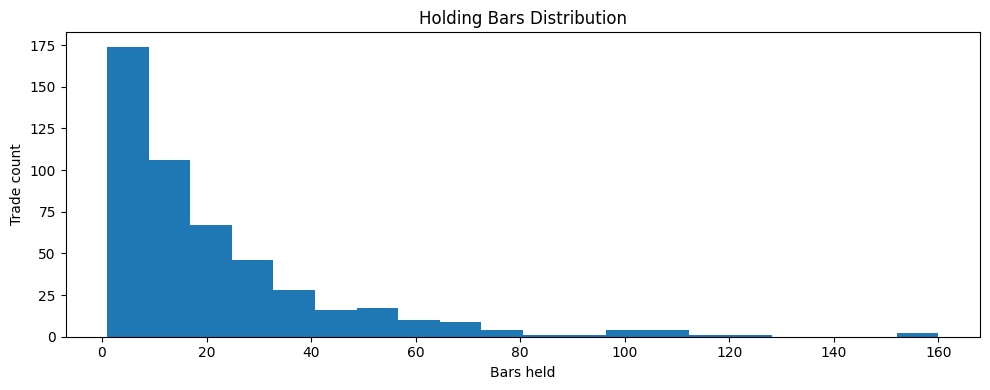

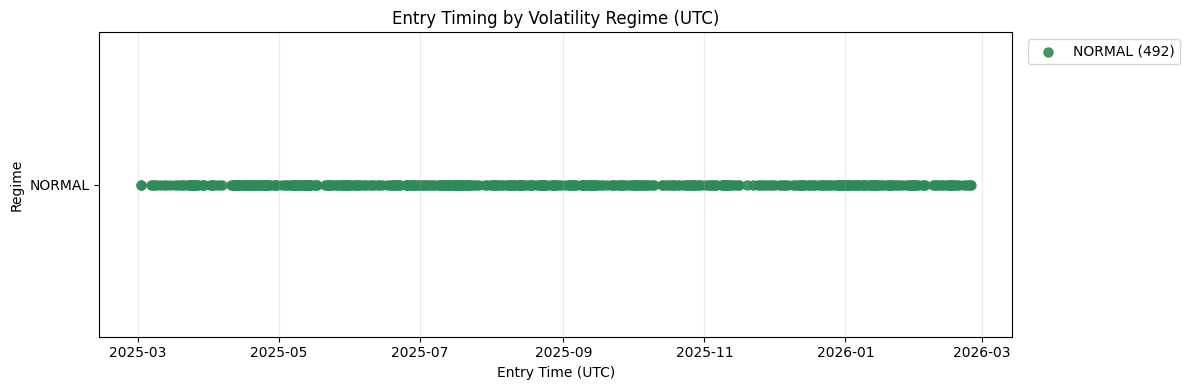

{'regime_counts': {'NORMAL': 492}}


In [5]:
import importlib
import importlib.util
import subprocess
from collections import Counter
from copy import deepcopy
from datetime import datetime

if importlib.util.find_spec('matplotlib') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])

import matplotlib.pyplot as plt

from research.src.adapters.csv_bar_repository import read_bars_from_csv
from research.src.domain.backtest_engine import run_backtest
import research.src.infra.research_config as research_config_module

summary = report.get('summary', {})
trades = report.get('trades', [])
no_signal_reasons = report.get('no_signal_reason_counts', {})

print('[chart] closed_trades =', summary.get('closed_trades'))
print('[chart] wins/losses =', summary.get('wins'), '/', summary.get('losses'))

def infer_entry_direction(trade):
    entry_price = trade.get('entry_price')
    stop_price = trade.get('stop_price')
    if entry_price is None or stop_price is None:
        return 'UNKNOWN'
    return 'LONG' if float(stop_price) < float(entry_price) else 'SHORT'

# TP_R_SWEEP
R_SWEEP_START = 1.5
R_SWEEP_END = 3.0
R_SWEEP_STEP = 0.1


def _build_r_values(start: float, end: float, step: float) -> list[float]:
    values = []
    index = 0
    current = start
    while current <= end + 1e-9:
        values.append(round(current, 2))
        index += 1
        current = start + step * index
    return values


bars_for_sweep = read_bars_from_csv(CSV_PATH)
research_config_module = importlib.reload(research_config_module)
base_config_for_sweep = research_config_module.load_bot_config(CONFIG_PATH)
r_values = _build_r_values(R_SWEEP_START, R_SWEEP_END, R_SWEEP_STEP)

tp_r_sweep_rows = []
for r_value in r_values:
    config_for_sweep = deepcopy(base_config_for_sweep)
    config_for_sweep['exit']['take_profit_r_multiple'] = r_value
    report_for_sweep = run_backtest(bars_for_sweep, config_for_sweep)
    summary_for_sweep = report_for_sweep.summary
    tp_r_sweep_rows.append(
        {
            'r_multiple': r_value,
            'closed_trades': summary_for_sweep.closed_trades,
            'win_rate_pct': summary_for_sweep.win_rate_pct,
            'total_pnl_pct': summary_for_sweep.total_pnl_pct,
            'total_scaled_pnl_pct': summary_for_sweep.total_scaled_pnl_pct,
            'average_scaled_pnl_pct': summary_for_sweep.average_scaled_pnl_pct,
        }
    )

print('[tp_r_sweep] range', {'start': R_SWEEP_START, 'end': R_SWEEP_END, 'step': R_SWEEP_STEP})
for row in tp_r_sweep_rows:
    print(row)

best_by_scaled = max(tp_r_sweep_rows, key=lambda row: row['total_scaled_pnl_pct'])
best_by_total = max(tp_r_sweep_rows, key=lambda row: row['total_pnl_pct'])
print('[tp_r_sweep] best_by_total_scaled_pnl_pct', best_by_scaled)
print('[tp_r_sweep] best_by_total_pnl_pct', best_by_total)

x_values = [row['r_multiple'] for row in tp_r_sweep_rows]
scaled_values = [row['total_scaled_pnl_pct'] for row in tp_r_sweep_rows]
win_rate_values = [row['win_rate_pct'] for row in tp_r_sweep_rows]
closed_trade_values = [row['closed_trades'] for row in tp_r_sweep_rows]

plt.figure(figsize=(12, 4))
plt.plot(x_values, scaled_values, marker='o', label='Total Scaled PnL (%)')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Take Profit R Sweep: Total Scaled PnL (%)')
plt.xlabel('take_profit_r_multiple')
plt.ylabel('Total Scaled PnL (%)')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

fig, axis_left = plt.subplots(figsize=(12, 4))
axis_left.plot(x_values, win_rate_values, marker='o', color='tab:blue', label='Win Rate (%)')
axis_left.set_xlabel('take_profit_r_multiple')
axis_left.set_ylabel('Win Rate (%)', color='tab:blue')
axis_left.tick_params(axis='y', labelcolor='tab:blue')
axis_left.grid(alpha=0.25)

axis_right = axis_left.twinx()
axis_right.plot(x_values, closed_trade_values, marker='s', color='tab:orange', label='Closed Trades')
axis_right.set_ylabel('Closed Trades', color='tab:orange')
axis_right.tick_params(axis='y', labelcolor='tab:orange')

lines_left, labels_left = axis_left.get_legend_handles_labels()
lines_right, labels_right = axis_right.get_legend_handles_labels()
axis_left.legend(lines_left + lines_right, labels_left + labels_right, loc='best')
plt.title('Take Profit R Sweep: Win Rate and Closed Trades')
plt.tight_layout()
plt.show()

# Summary preview
trades_preview = report.get('trades', [])[:5]
top_reasons = sorted(no_signal_reasons.items(), key=lambda item: item[1], reverse=True)
{
    'top_no_signal_reasons': top_reasons[:10],
    'trades_preview': trades_preview,
}

# 1) Top no-signal reasons
reason_items = sorted(no_signal_reasons.items(), key=lambda item: item[1], reverse=True)[:10]
if reason_items:
    labels = [item[0] for item in reason_items]
    values = [item[1] for item in reason_items]

    plt.figure(figsize=(14, 5))
    plt.bar(range(len(labels)), values)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title('Top 10 NO_SIGNAL Reasons')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('No no-signal reasons. Top reason chart skipped.')

# 2) Exit reason distribution
closed_trades = [trade for trade in trades if trade.get('exit_reason') != 'OPEN']
if not closed_trades:
    print('No closed trades yet. Exit reason chart skipped.')
else:
    exit_counts = Counter(trade.get('exit_reason', 'UNKNOWN') for trade in closed_trades)
    labels = list(exit_counts.keys())
    values = [exit_counts[label] for label in labels]

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Exit Reason Distribution')
    plt.tight_layout()
    plt.show()

# 2b) Entry direction distribution (inferred from stop side)
all_trades_with_direction = [
    trade for trade in trades if trade.get('entry_price') is not None and trade.get('stop_price') is not None
]
if not all_trades_with_direction:
    print('No trades with direction data. Direction chart skipped.')
else:
    direction_counts = Counter(infer_entry_direction(trade) for trade in all_trades_with_direction)
    ordered_direction_labels = [
        label
        for label in ['LONG', 'SHORT', 'UNKNOWN']
        if label in direction_counts
    ]
    direction_values = [direction_counts[label] for label in ordered_direction_labels]

    plt.figure(figsize=(8, 4))
    plt.bar(ordered_direction_labels, direction_values)
    plt.title('Entry Direction Distribution (Inferred)')
    plt.ylabel('Trade count')
    plt.tight_layout()
    plt.show()

    closed_direction_counts = Counter(infer_entry_direction(trade) for trade in closed_trades)
    print(
        {
            'all_trade_direction_counts': dict(direction_counts),
            'closed_trade_direction_counts': dict(closed_direction_counts),
        }
    )

# 3) Equity / Drawdown / Cumulative PnL
pnl_metric_key = 'scaled_pnl_pct' if any(trade.get('scaled_pnl_pct') is not None for trade in closed_trades) else 'pnl_pct'
directional_total_pnl_pct = {}
for direction_label in ['LONG', 'SHORT', 'UNKNOWN']:
    directional_values = [
        float(trade.get(pnl_metric_key))
        for trade in closed_trades
        if infer_entry_direction(trade) == direction_label and trade.get(pnl_metric_key) is not None
    ]
    if directional_values:
        directional_total_pnl_pct[direction_label] = round(sum(directional_values), 6)
print({'directional_total_pnl_pct': directional_total_pnl_pct, 'pnl_metric_key': pnl_metric_key})
pnl_pct_values = [trade.get(pnl_metric_key) for trade in closed_trades if trade.get(pnl_metric_key) is not None]

if not pnl_pct_values:
    print('No closed trades yet. Equity / drawdown charts skipped.')
else:
    cumulative = []
    running = 0.0
    for value in pnl_pct_values:
        running += float(value)
        cumulative.append(running)

    equity_curve = []
    equity = float(INITIAL_CAPITAL_JPY)
    for value in pnl_pct_values:
        equity *= 1.0 + float(value) / 100.0
        equity_curve.append(equity)

    peaks = []
    drawdowns = []
    peak = equity_curve[0]
    for value in equity_curve:
        peak = max(peak, value)
        peaks.append(peak)
        drawdowns.append((value / peak) - 1.0)

    max_drawdown = min(drawdowns)
    max_drawdown_pct = max_drawdown * 100.0
    max_dd_trade_index = drawdowns.index(max_drawdown) + 1

    final_asset = equity_curve[-1]
    total_return_pct = ((final_asset / float(INITIAL_CAPITAL_JPY)) - 1.0) * 100.0

    print(
        {
            'pnl_metric_key': pnl_metric_key,
            'initial_capital_jpy': int(INITIAL_CAPITAL_JPY),
            'final_asset_jpy': round(final_asset, 2),
            'total_return_pct': round(total_return_pct, 4),
            'max_drawdown_pct': round(max_drawdown_pct, 4),
            'max_drawdown_trade_index': max_dd_trade_index,
        }
    )

    x = list(range(1, len(equity_curve) + 1))

    plt.figure(figsize=(12, 4))
    plt.plot(x, equity_curve, marker='o', label='Asset (JPY)')
    plt.plot(x, peaks, linestyle='--', linewidth=1.2, label='Rolling Peak')
    plt.scatter(
        [max_dd_trade_index],
        [equity_curve[max_dd_trade_index - 1]],
        color='red',
        zorder=5,
        label=f'Max DD {max_drawdown_pct:.2f}%',
    )
    plt.title(f'Asset Curve (Initial {INITIAL_CAPITAL_JPY:,} JPY, metric={pnl_metric_key})')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Asset (JPY)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3.5))
    drawdown_pct_series = [value * 100.0 for value in drawdowns]
    plt.plot(x, drawdown_pct_series, color='crimson')
    plt.fill_between(x, drawdown_pct_series, 0, color='crimson', alpha=0.2)
    plt.axhline(0, linestyle='--', linewidth=1, color='black')
    plt.title('Drawdown Curve (%)')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Drawdown (%)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title(f'Cumulative PnL (%) by Closed Trade ({pnl_metric_key})')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Cumulative PnL (%)')
    plt.tight_layout()
    plt.show()

# 4) Holding bars histogram
holding_bars = [trade.get('holding_bars') for trade in closed_trades if trade.get('holding_bars') is not None]
if not holding_bars:
    print('No closed trades yet. Holding bars histogram skipped.')
else:
    unique_count = len(set(holding_bars))
    bins = min(max(unique_count, 5), 20)

    plt.figure(figsize=(10, 4))
    plt.hist(holding_bars, bins=bins)
    plt.title('Holding Bars Distribution')
    plt.xlabel('Bars held')
    plt.ylabel('Trade count')
    plt.tight_layout()
    plt.show()

# 5) Entry timing by volatility regime
entry_trades = sorted(
    [trade for trade in trades if trade.get('entry_time')],
    key=lambda trade: trade['entry_time'],
)

if not entry_trades:
    print('No entry trades yet. Regime timing chart skipped.')
else:
    def regime_from_multiplier(multiplier):
        if multiplier is None:
            return 'UNKNOWN'
        value = round(float(multiplier), 2)
        if value <= 0.50:
            return 'STORM'
        if value <= 0.75:
            return 'VOLATILE'
        if value == 1.00:
            return 'NORMAL'
        return f'CUSTOM_{value:.2f}'

    regime_colors = {
        'STORM': 'crimson',
        'VOLATILE': 'darkorange',
        'NORMAL': 'seagreen',
        'UNKNOWN': 'gray',
    }

    regime_to_times = {}
    for trade in entry_trades:
        regime = regime_from_multiplier(trade.get('position_size_multiplier'))
        entry_time = datetime.fromisoformat(trade['entry_time'].replace('Z', '+00:00'))
        regime_to_times.setdefault(regime, []).append(entry_time)

    ordered_regimes = [regime for regime in ['STORM', 'VOLATILE', 'NORMAL', 'UNKNOWN'] if regime in regime_to_times]
    custom_regimes = sorted(
        [
            regime
            for regime in regime_to_times
            if regime not in {'STORM', 'VOLATILE', 'NORMAL', 'UNKNOWN'}
        ]
    )
    ordered_regimes.extend(custom_regimes)

    y_map = {regime: index for index, regime in enumerate(ordered_regimes)}

    plt.figure(figsize=(12, 4))
    for regime in ordered_regimes:
        times = regime_to_times.get(regime, [])
        if not times:
            continue
        y_values = [y_map[regime]] * len(times)
        color = regime_colors.get(regime, 'steelblue')
        plt.scatter(
            times,
            y_values,
            s=42,
            alpha=0.9,
            color=color,
            label=f"{regime} ({len(times)})",
        )

    plt.yticks([y_map[regime] for regime in ordered_regimes], ordered_regimes)
    plt.title('Entry Timing by Volatility Regime (UTC)')
    plt.xlabel('Entry Time (UTC)')
    plt.ylabel('Regime')
    plt.grid(axis='x', alpha=0.25)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.show()

    regime_counts = {regime: len(times) for regime, times in regime_to_times.items()}
    print({'regime_counts': regime_counts})

